# Demo for inference using pre-trained symbolic beat tracker

## Prediction

In [1]:
import yaml
import torch

from models.beat_track_plmodule import BeatTrackPLModule
from models.crnn_beat_model import CRNNBeatModel
from data.io import read_note_sequence


####################################################
# User Configurations
####################################################

## Model checkpoint path or state dict path
# If you are using the pre-trained model (model state dict) from Maz-5, please set the path here:
ckpt_path = '/home/lel79bc/repositories/ssl-beat-tracking/B1_beat_track_symbolic/model_checkpoints/fold0.pt'
# If you are using the your trained model checkpoint from the wandb logs, please set the path here and set use_state_dict to False:
# ckpt_path = '/home/lel79bc/repositories/CrossModalBeat-Symbolic/symbolic_beat_tracker/wandb-logs/CrossModalBeat-Symbolic-symbolic_beat_tracker/2dl2o4kh/checkpoints/best.ckpt'

## Set path to the config yaml file
config_path = 'config.yaml'

## load a test MIDI piece
midi_fn = '/mnt/c/Users/lel79bc/Desktop/Datasets/Maz-5/bytedance/Chopin_Op068No3_Ashkenazy-1981_pid9058b-19.mid'


####################################################
# Load the model and predict
####################################################

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load the trained model checkpoint
config = yaml.safe_load(open(config_path, 'r'))

if ckpt_path.endswith('.pt'):
    model = CRNNBeatModel(
        hidden_size = config['model']['init_args']['hidden_size'],
        num_layers_convs = config['model']['init_args']['num_layers_convs'],
        num_layers_gru = config['model']['init_args']['num_layers_gru'],
        kernel_size = config['model']['init_args']['kernel_size'],
        dropout = config['model']['init_args']['dropout'],
    )
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
else:
    module = BeatTrackPLModule.load_from_checkpoint(ckpt_path, **config['model']['init_args'], map_location=device)
    model = module.model
    
model.eval()

## Read the MIDI note sequence
note_seq = read_note_sequence(midi_fn)

## Predict
x = torch.tensor(note_seq).unsqueeze(0).to(device)
y_b, y_db = model(x)
beat_probs = torch.sigmoid(y_b).squeeze(0).detach().numpy()
downbeat_probs = torch.sigmoid(y_db).squeeze(0).detach().numpy()

print(beat_probs[:20])
print(downbeat_probs[:20])

/home/lel79bc/anaconda3/envs/torch_env_2025/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0.98692244 0.98952734 0.9846906  0.95567477 0.00789891 0.00818109
 0.00611407 0.00536777 0.9759696  0.9945682  0.99433184 0.9906076
 0.99421304 0.9974349  0.9972779  0.9880797  0.98665875 0.99102986
 0.99277157 0.99220663]
[0.9425957  0.9549516  0.9486993  0.90525305 0.00810932 0.00607583
 0.00473681 0.00613677 0.01360666 0.02039621 0.01914153 0.01820721
 0.00690986 0.00807443 0.00804879 0.00597448 0.9383671  0.9717837
 0.9790927  0.98018724]


## Visualisation

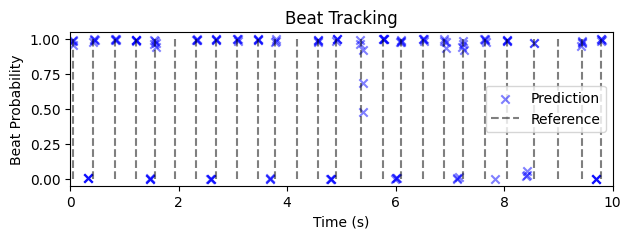

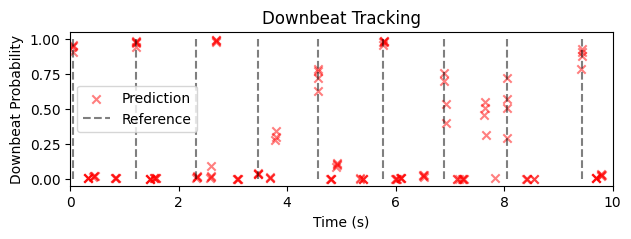

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ground truth beat annotations
annot = pd.read_csv('/mnt/c/Users/lel79bc/Desktop/Datasets/Maz-5/annotations_beatMeasure_FiveMazurkas_FD/Chopin_Op068No3/Chopin_Op068No3_Ashkenazy-1981_pid9058b-19.csv', header=None)
beats_targ = annot[0].to_numpy()
downbeats_targ = np.array([annot[0][i] for i in range(len(annot)) if annot[1][i] % 1 == 0])

# Get onset times for each note
onsets = note_seq[:, 1]

# Plot - Beat tracking
plt.figure(figsize=(7, 2))
plt.scatter(onsets, beat_probs, color='blue', label='Prediction', marker='x', alpha=0.5)
plt.vlines(beats_targ, 0, 1, color='black', linestyle='dashed', label='Reference', alpha=0.5)
plt.xlim([0, 10])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Beat Probability')
plt.title('Beat Tracking')
plt.show()

# Plot - Downbeat tracking
plt.figure(figsize=(7, 2))
plt.scatter(onsets, downbeat_probs, color='red', label='Prediction', marker='x', alpha=0.5)
plt.vlines(downbeats_targ, 0, 1, color='black', linestyle='dashed', label='Reference', alpha=0.5)
plt.xlim([0, 10])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Downbeat Probability')
plt.title('Downbeat Tracking')
plt.show()